In [13]:
import numpy as np
import json
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import tikzplotlib

In [ ]:
dataDir = "./data/openface"

In [ ]:
def readOpenFaceFile(filename) -> [dict]:
  lines = []
  with open(f"{dataDir}/{filename}", "r") as f:
      for l in f:
        detectionStr = l.split(",", maxsplit=1)[1].rstrip().strip("\"")
        detectionStr = detectionStr.replace("\'", "\"")
        lines.append(json.loads(detectionStr))
  return lines

In [ ]:
def getNumOfNoDetections(frames: [dict]) -> int:
  return len([f for f in frames if f["intensity"] == "-1" or f["intensity"]["AU01"] == "-"])

In [ ]:
def getNumOfZeroIntensity(frames: [dict]) -> int:
  return len([f for f in frames if f["intensity"] != "-1" and f["intensity"]["AU06"] == 0 and f["intensity"]["AU12"] == 0])

In [ ]:
def getCumulativeNoDetections(frames: [dict]) -> [int]:
  return [getNumOfNoDetections(frames[:i]) for i in range(len(frames))]

In [ ]:
videos = ["bright", "dark", "outside", "moving_background", "hololens_left", "hololens_right"]
bitrates = ["750", "1500"]
methods = ["none", "face", "fes"]

In [ ]:
def print_stats(data, name):
    print("Avg {} per method".format(name))
    a = data.reshape(len(videos)*len(bitrates), len(methods))
    avgs = np.mean(a, axis=0)
    print(pd.DataFrame(avgs, index=methods))

    print("\nAvg {} per video".format(name))
    a = data.reshape(len(videos), len(bitrates)*len(methods))
    avgs = np.mean(a, axis=1)
    print(pd.DataFrame(avgs, index=videos))

    print("\nAvg {} per bitrate".format(name))
    a = data.swapaxes(1, 2).reshape(len(videos)*len(methods), len(bitrates))
    avgs = np.mean(a, axis=0)
    print(pd.DataFrame(avgs, index=bitrates))

    print("\nAvg {} method and bitrate".format(name))
    avgs = np.mean(data, axis=0)
    print(pd.DataFrame(avgs, index=bitrates, columns=methods))

    print("\nAvg {} per video and bitrate".format(name))
    avgs = np.mean(data, axis=2)
    print(pd.DataFrame(avgs, index=videos, columns=bitrates))

    print("\nAvg {} per video and method".format(name))
    avgs = np.mean(data, axis=1)
    print(pd.DataFrame(avgs, index=videos, columns=methods))


In [ ]:
def plot_stats(data_c, label):
    data_c_750 = data_c[:, 0, :]
    data_c_1500 = data_c[:, 1, :]

    x = np.arange(len(videos))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

    for i in range(len(methods)):
        offset = width * multiplier
        ax1.bar(x + offset, data_c_750[:, i], width, label=methods[i])
        ax2.bar(x + offset, data_c_1500[:, i], width, label=methods[i])
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_ylabel(label)
    ax2.set_ylabel(label)
    ax1.set_xlabel('Video')
    ax2.set_xlabel('Video')
    ax1.set_xticks(x + width, videos)
    ax2.set_xticks(x + width, videos)
    ax1.legend()
    ax2.legend()
    ax1.set_title('750 kbit/s')
    ax2.set_title('1500 kbit/s')
    fig.suptitle('{} by video and method'.format(label))
    fig.set_figwidth(15)

    plt.show()

In [ ]:
def plot_cumNoDetects(cumRatios):
    plt.plot(cumRatios)
    plt.show()

In [26]:
valuesDetect = []
cumValuesDetect = []

for v in videos:
    for b in bitrates:
        for m in methods:
            frames = readOpenFaceFile(f"{v}_{b}_{m}.csv")
            noDetecs = getNumOfNoDetections(frames)
            cumNoDetecs = getCumulativeNoDetections(frames)
            zeroItensity = getNumOfZeroIntensity(frames)
            ratio = noDetecs/len(frames)
            cumRatio = np.array(cumNoDetecs)/len(frames)
            valuesDetect.append(ratio)
            cumValuesDetect.append(cumRatio)
            # print(f"{v}_{b}_{m}: {noDetecs}/{len(frames)} = {ratio:.3f}")

valuesDetect = np.array(valuesDetect).reshape(len(videos),len(bitrates),len(methods))

In [ ]:
valuesDetect_none_750 = valuesDetect[:,0,0]
valuesDetect_none_1500 = valuesDetect[:,1,0]
valuesDetect_face_750 = valuesDetect[:,0,1]
valuesDetect_face_1500 = valuesDetect[:,1,1]
valuesDetect_fes_750 = valuesDetect[:,0,2]
valuesDetect_fes_1500 = valuesDetect[:,1,2]

print(stats.ttest_ind(valuesDetect_none_1500, valuesDetect_face_1500))
print(stats.ttest_ind(valuesDetect_none_1500, valuesDetect_fes_1500))

In [31]:
print_stats(valuesDetect, "detections")

Avg detections per method
             0
none  0.230311
face  0.224007
fes   0.223008

Avg detections per video
                          0
bright             0.224322
dark               0.267775
outside            0.202307
moving_background  0.200369
hololens_left      0.293542
hololens_right     0.166337

Avg detections per bitrate
             0
750   0.209835
1500  0.241716

Avg detections method and bitrate
          none      face       fes
750   0.215897  0.201522  0.212087
1500  0.244725  0.246493  0.233929

Avg detections per video and bitrate
                        750      1500
bright             0.206069  0.242576
dark               0.246365  0.289186
outside            0.188786  0.215828
moving_background  0.179382  0.221356
hololens_left      0.288563  0.298520
hololens_right     0.149847  0.182827

Avg detections per video and method
                       none      face       fes
bright             0.246368  0.209236  0.217363
dark               0.276911  0.255086  0.2

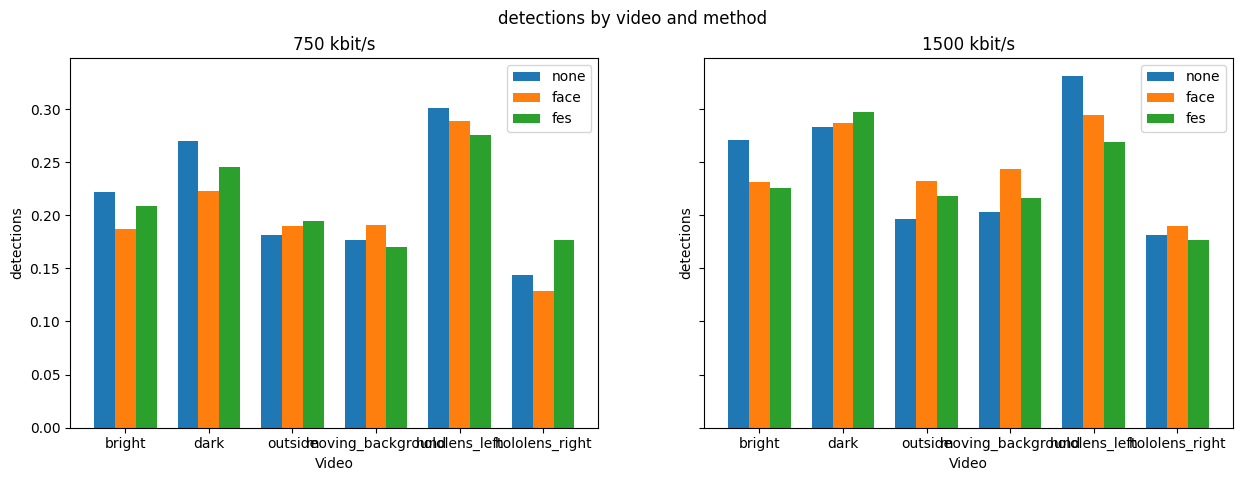

In [29]:
plot_stats(valuesDetect, "detections")

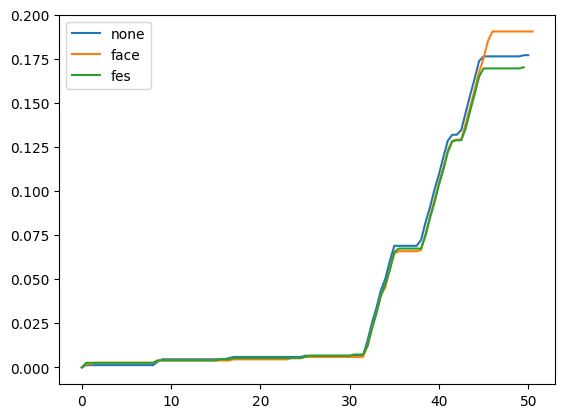

In [28]:
def plot_cumNoDetects(cumNoDetecs, video, bitrate):
  secondsArr = [np.array(range(len(cumNoDetecs[i]))) / 30 for i in range(len(cumNoDetecs))]
  
  # only use every third value
  cumNoDetecs = [cumNoDetecs[i][::15] for i in range(len(cumNoDetecs))]
  secondsArr = [secondsArr[i][::15] for i in range(len(secondsArr))]

  vI = videos.index(video)
  bI = bitrates.index(bitrate)

  startIndex = vI*6+bI*3
  plt.plot(
    secondsArr[startIndex],cumNoDetecs[startIndex],
    secondsArr[startIndex+1],cumNoDetecs[startIndex+1],
    secondsArr[startIndex+2],cumNoDetecs[startIndex+2]
    # secondsArr[0*6],cumNoDetecs[0*6],
    # secondsArr[1*6],cumNoDetecs[1*6],
    # secondsArr[2*6],cumNoDetecs[2*6],
    # secondsArr[3*6],cumNoDetecs[3*6],
    # secondsArr[4*6],cumNoDetecs[4*6],
    # secondsArr[5*6],cumNoDetecs[5*6]
  )
  plt.legend(["none", "face", "fes"])
  # tikzplotlib.save("openface-video-comp.tex")
  plt.show()
plot_cumNoDetects(cumValuesDetect, "moving_background", "750")